# Kernel regression

**What you will learn today**: You will learn how to implement kernel regression. First we analyze a synthetic dataset: you will build the feature map associated with different kernels and we see how the learning performance can be different. As always after having understood the theoretical insights we step on to real-dataset problem: you can play using our dear friend sklearn to implement Kernel Ridge Regression, with a kernel of your choice.


# 1) KRR from scratch 

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Remember first lecture?  Let us use pandas for handling synthetic dataset

In [80]:
data = pd.read_csv('dataTP8.csv')
data.head()

,X,Y
0,0.352375,0.089555
1,4.895123,-1.280276
2,1.866624,1.289304
3,3.507061,-0.268157
4,3.380874,-0.206807


In [81]:
x,y = np.array(data['X']), np.array(data['Y'])

Let's see how it looks like

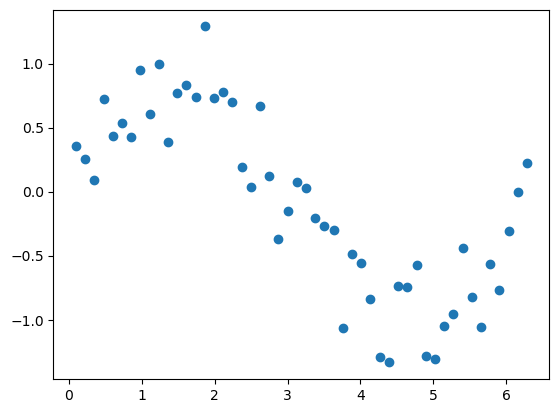

In [82]:
plt.plot(x,y,'o') 

It does not seem a bad idea to use a polynomial fitting here. We have introduced in the theoretical lectures kernel methods: $$K(x,y) = {\phi(x)}^T{\phi(y)}$$

Let us pick for the first part of the analysis a feature map of the form:
$$ \phi_k^{(p)}(x) = x^k  \,\,\,\,\,\,\,\, k=1 \dots p $$

You may have studied this under the name *linear basis regression*.

The tools we need once we have mapped the datapoints in feature space are the usual one of linear regression as we know and all will be straight-forward.
We will study the behaviour as the degree $p$ varies, this will vary the complexity of the fitting model leading us to our usual bias-variance tradeoff consideration.

In [83]:
def build_poly(x, degree,choice='none',gamma=1):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    x_pol = []
    
    for i in range(0,len(x)):
        x_pol_ele = []
        if choice == "rbf":
          x_pol_ele = np.exp(-x[i]*x[i]/gamma)*np.array([x[i]**j/(np.math.factorial(j)*np.math.sqrt(gamma**j)) for j in range(0,degree+1)])
        else:
          x_pol_ele = np.array([x[i]**j for j in range(0,degree+1)])
        x_pol.append(x_pol_ele)
    return np.array(x_pol)

def ridge_regression(y, X, lambda_):
    """implement ridge regression."""
    Xt = np.transpose(X)
    I = np.eye(len(Xt))
    w =  np.linalg.solve(Xt@X + (2*lambda_*len(y))*I,Xt@y)
    mse = (1/(2*len(y)))*np.sum((y-np.matmul(X,w))**2)
    return mse,w

def polynomial_regression(x,y,degrees,lambda_):
    num = len(degrees)
    fig, axs = plt.subplots(num,figsize=(15,15)) ; i =-1
    for degree in (degrees):
        i+=1   ; phi = build_poly(x, degree)
        
        mse , weights = ridge_regression(y, phi,lambda_)
        rmse = np.sqrt(2*mse)

        print("Processing {j}th experiment, degree={d}, rmse={loss}".format(
              j=i + 1, d=degree, loss=rmse))
        # print(weights)
        # plot fit
        # fhat = np.dot(phi,weights)
        xvals = np.arange(min(x) - 0.1, max(x) + 0.1, 0.1)
        phi = build_poly(xvals, degree) ; fhat = np.dot(phi,weights)
        axs[i].plot(x,
            y, 'o',label=f'Degree={degree} -- Data')
        axs[i].plot(xvals,
            fhat,label=f'Fit')
        axs[i].set_ylim([-1.4,1.4])
        axs[i].legend()
    # plt.tight_layout()
    

Processing 1th experiment, degree=5, rmse=0.2545435645039997
Processing 2th experiment, degree=12, rmse=0.24444839387411157
Processing 3th experiment, degree=20, rmse=0.24400037311396838
Processing 4th experiment, degree=50, rmse=0.23857894431143548
Processing 5th experiment, degree=80, rmse=0.21161819816417182
Processing 6th experiment, degree=120, rmse=0.21320216608843776
Processing 7th experiment, degree=160, rmse=0.21154066768255633


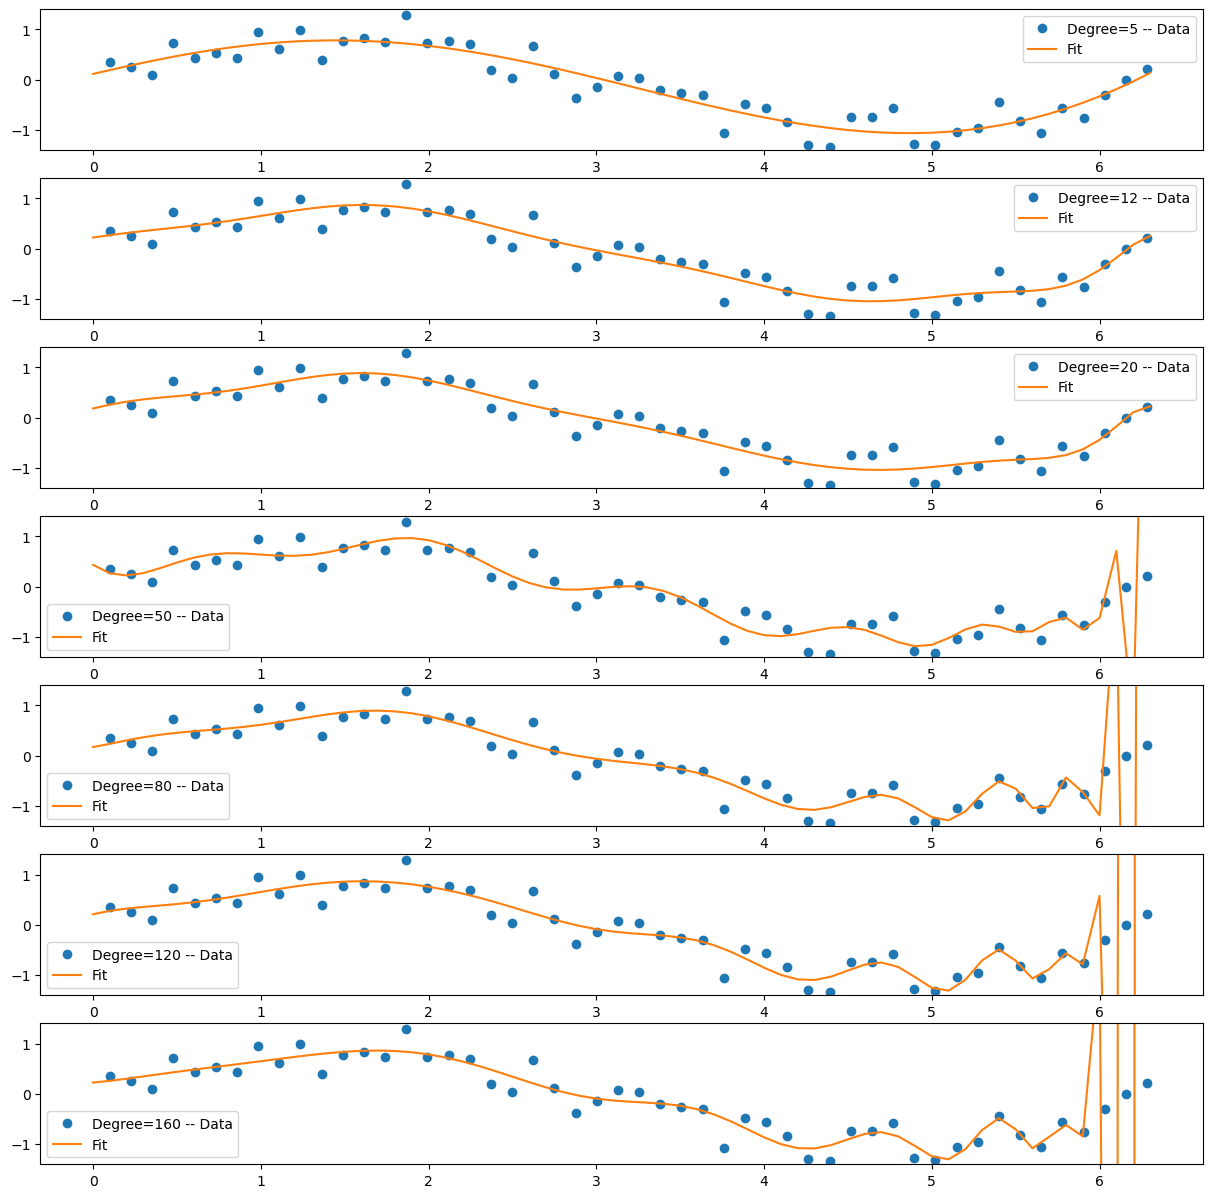

In [84]:
degrees = [5,  12, 20,50,80,120,160] ; lambda_ = 10e-6
polynomial_regression(x,y,degrees,lambda_)

We clearly see that by choosing a value of the degree too high we start to have bad fitting (i.e. overfitting). This feature map is not building a good kernel for studying the data.

It is interesting to understand if we can build another feature map, always in a polynomial fashion, that is able to having good learning rates.

First let's introduce some functions to split data in training and testing dataset to evaluate the performance of the model.

In [85]:
def split_data(x, y, ratio, seed=1):
    # set seed
    np.random.seed(seed)
    # ***************************************************
    index = np.arange(0,len(x))
    index_train = np.random.choice(index, int(ratio*len(x)), replace=False)
    
    x_train = x[index_train]
    training_y = y[index_train]
    test_x = x[[i for i in range(len(x)) if i not in index_train]]
    test_y = y[[i for i in range(len(y)) if i not in index_train]]
    
    return x_train, training_y, test_x, test_y

## Exercise
* Implement kernel regression with the feature map parametrized by $\gamma$ which we encode with the codework *rbf*: 

$$ \phi_k^{(p)}(x) = e^{\frac{-x^2}{\gamma}}\frac{x^k}{k!}  \,\,\,\,\,\,\,\, k=1 \dots p $$
* Fixing a high degree, for example 100, study the behaviour as a function of $\lambda$ and $\gamma$ of the learning curves (test error and training error) and compare with what you would see with the previous feature map.
* What do you conclude?



In [86]:
def ridge_regression_learning_curves(x, y, degree, ratio, lambdas, seed, choice , gamma):
   
    x_train,y_train,x_test,y_test = split_data(x, y, ratio, seed)

    phi_train = build_poly(x_train, degree,choice,gamma)
    phi_test = build_poly(x_test, degree,choice,gamma)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        mse_train,w = ridge_regression(y_train, phi_train, lambda_)
        rmse_tr.append(np.sqrt(2*mse_train))
        
        mse_test = (1/(2*len(y_test)))*np.sum((y_test-np.matmul(phi_test,w))**2)
        rmse_te.append(np.sqrt(2*mse_test))

    return rmse_tr , rmse_te

C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_22088\1365334909.py:8: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  x_pol_ele = np.exp(-x[i]*x[i]/gamma)*np.array([x[i]**j/(np.math.factorial(j)*np.math.sqrt(gamma**j)) for j in range(0,degree+1)])


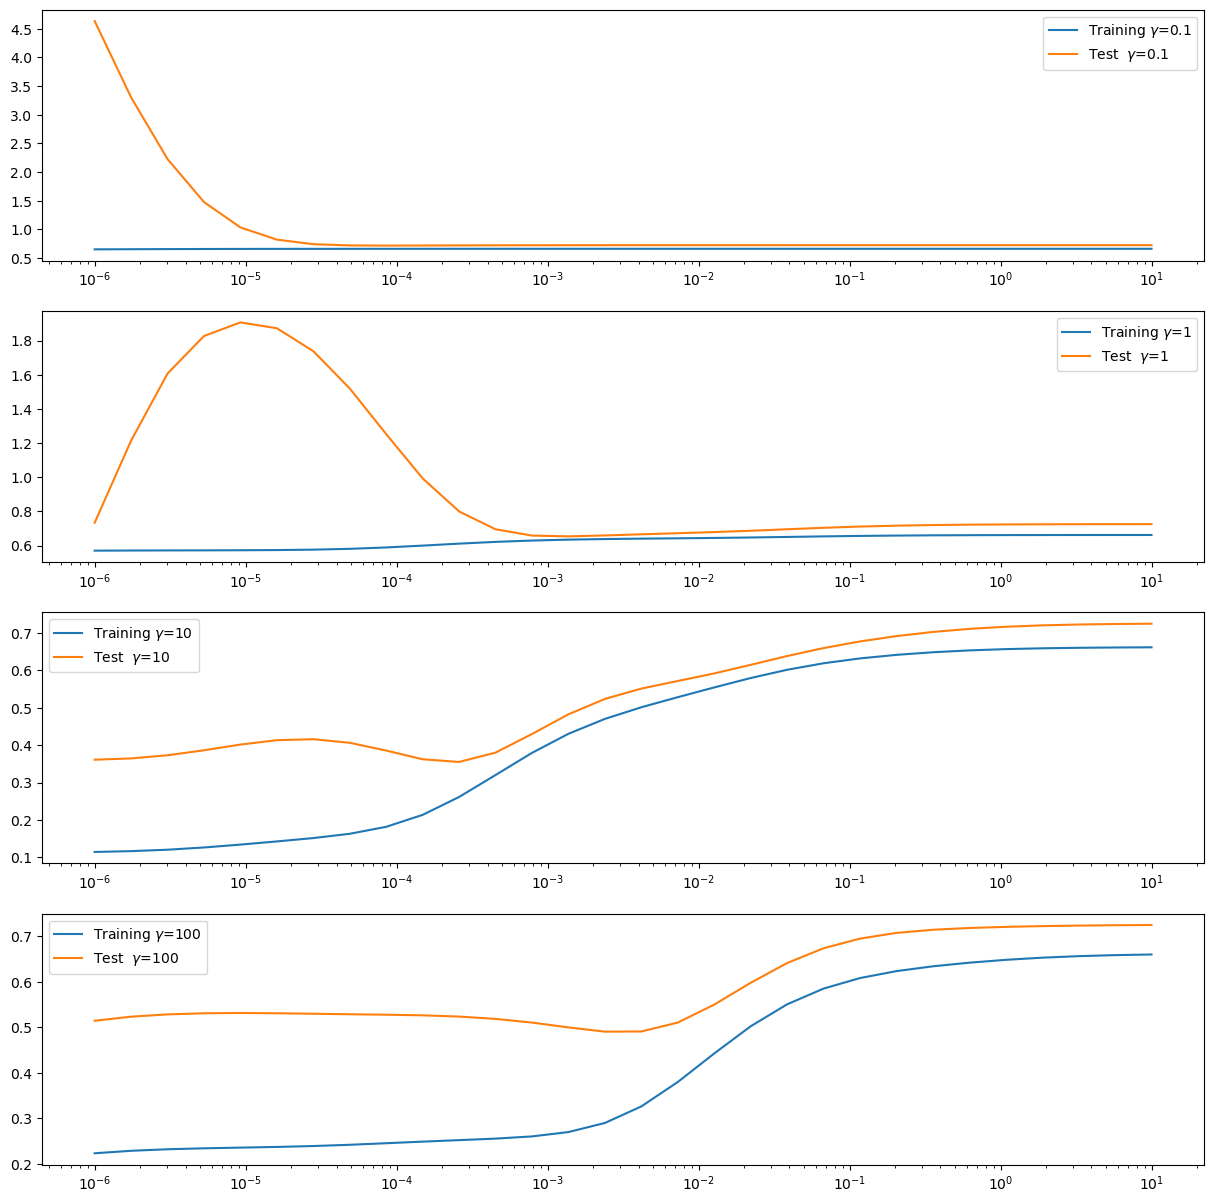

In [87]:
seed = 1975  ; degree = 10  ; split_ratio = 0.2   ; gammas = [0.1,1,10,100] ; choice = 'rbf'  ; lambdas = np.logspace(-6, 1, 30)
fig, ax = plt.subplots(len(gammas), figsize = (15,15)) 
for i,gamma in enumerate(gammas):
  a,b = ridge_regression_learning_curves(x, y, degree, split_ratio, lambdas,seed,choice , gamma)
  ax[i].plot(lambdas,a,label=f"Training $\gamma$={gamma}") ;  ax[i].plot(lambdas,b,label=f"Test  $\gamma$={gamma}") 
  ax[i].legend() ; ax[i].set_xscale('log') 

No more overfitting!

# 2) Kernel methods using Sklearn 

We have seen how to build Kernel Ridge Regression (KRR) from scratch starting from the feature map. The idea to map datapoint in an higher dimensional space (i.e. kernel trick) can be used also in classification task. We will consider again our old friend MNIST, we will consider SVC (Support Vector Classification). We will see that, at stake with previous lecture, *SVC* will accept the parameter *kernel* to choose in which space mapping our datapoints.

In [64]:
import time

from sklearn.datasets import fetch_openml # MNIST data
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

print(__doc__)

# Turn down for faster convergence
t0 = time.time()
train_size = 9000 # 60000
test_size = 1500 # 10000

### load MNIST data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', return_X_y=True, as_frame=False)
X = np.array(X)[:train_size+test_size]
y = np.array(y)[:train_size+test_size]


Automatically created module for IPython interactive environment


c:\Users\Yass La Menace\anaconda3\envs\Coding\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Let's plot an image to see how it looks like with plt.imshow.

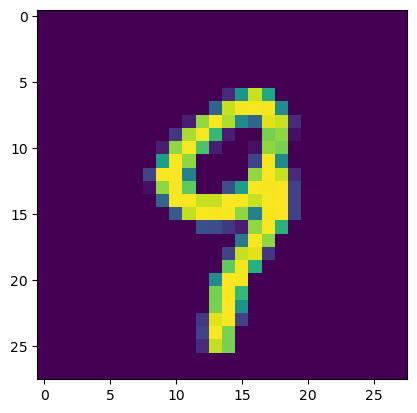

In [65]:
plt.imshow(X[6542,:].reshape(28,28))

We shuffle the data and we do the test-train splitting.

In [66]:
# shuffle data
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
# pick training and test data sets 
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size,test_size=test_size)

We preproccess the data and use StandardScaler to have zero mean and unit variance. Pay attention that we do that only on the training set!

In [67]:
# scale data to have zero mean and unit variance [required by regressor]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Exercise
- Repeat what you did in the previous lecture for a "linear" SVM classifier with the *rbf* kernel.
- Go and search the Python doc for SVM classifier to see how to implement it. 
- Optimize the regularization parameter using CV. Use default value for the parameter which characterize the kernel (e.g. variance in the gaussian kernel) and change *C* between $10^{-5}$ and $10^5$.
- How is the $\gamma$ hyperparameter fixed by default in the *rbf* implemented in sklearn? Try to play with the choice of $\gamma$ and see (qualitatively) what happens.

In [68]:
from sklearn.svm import SVC

In [69]:
# scale data to have zero mean and unit variance [required by regressor]
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.2,test_size=0.1)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [70]:
# using linear kernel, C=1, default value of gamma

# model
model = SVC(kernel='rbf',max_iter=10000,C=0.01)

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

In [71]:
model.score(X_test,y_test)

0.17714285714285713

In [72]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pandas as pd


In [88]:

# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 10)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'C': np.logspace(-5,5,10)}]


# specify model
model = SVC(kernel='rbf',max_iter=1000)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=SVC(max_iter=1000),
             param_grid=[{'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [89]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.833671,0.023038,0.389047,0.008174,0.00001,{'C': 1e-05},0.128571,0.073810,0.107143,0.121429,...,0.108571,0.018904,8,0.117262,0.118452,0.122619,0.119048,0.121429,0.119762,0.001971
1,0.819480,0.010458,0.389017,0.004958,0.000129,{'C': 0.0001291549665014884},0.128571,0.073810,0.107143,0.121429,...,0.108571,0.018904,8,0.117262,0.118452,0.122619,0.119048,0.121429,0.119762,0.001971
2,0.896184,0.066979,0.410644,0.018258,0.001668,{'C': 0.0016681005372000592},0.128571,0.073810,0.107143,0.121429,...,0.108571,0.018904,8,0.117262,0.118452,0.122619,0.119048,0.121429,0.119762,0.001971
3,1.184170,0.197501,0.499645,0.056664,0.021544,{'C': 0.021544346900318846},0.304762,0.273810,0.300000,0.319048,...,0.303810,0.017077,7,0.290476,0.311905,0.299405,0.317857,0.325000,0.308929,0.012474
4,0.568003,0.073072,0.345074,0.020585,0.278256,{'C': 0.2782559402207126},0.866667,0.811905,0.878571,0.859524,...,0.851429,0.023309,6,0.905357,0.916071,0.894048,0.902976,0.905952,0.904881,0.007037
5,0.451006,0.017404,0.284968,0.019702,3.593814,{'C': 3.593813663804626},0.923810,0.869048,0.916667,0.907143,...,0.901905,0.019425,1,1.000000,0.998214,0.997619,0.999405,0.998810,0.998810,0.000842
6,0.423696,0.005818,0.285014,0.016176,46.415888,{'C': 46.41588833612782},0.921429,0.866667,0.919048,0.907143,...,0.900476,0.020614,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,0.421263,0.011907,0.272930,0.011171,599.48425,{'C': 599.4842503189421},0.921429,0.866667,0.919048,0.907143,...,0.900476,0.020614,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,0.412782,0.011339,0.274493,0.008527,7742.636827,{'C': 7742.636826811277},0.921429,0.866667,0.919048,0.907143,...,0.900476,0.020614,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,0.409546,0.011676,0.274532,0.006129,100000.0,{'C': 100000.0},0.921429,0.866667,0.919048,0.907143,...,0.900476,0.020614,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [90]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9019047619047619 corresponding to hyperparameters {'C': 3.593813663804626}
